In [31]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import clone

In [32]:
# 1. Load data
train_path = "C:/Users/User/Downloads/train.csv"
test_path  = "C:/Users/User/Downloads/test.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (1460, 81)
Test shape: (1459, 80)


In [33]:
# Keeping test IDs for the final csv
test_ids = test_df["Id"].copy()

In [34]:
# 2. Feature engineering

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # TotalSF = GrLivArea + TotalBsmtSF
    if {"GrLivArea", "TotalBsmtSF"}.issubset(df.columns):
        df["TotalSF"] = df["GrLivArea"] + df["TotalBsmtSF"]
    else:
        df["TotalSF"] = np.nan

    # TotalBaths = FullBath + 0.5*HalfBath
    full = df["FullBath"] if "FullBath" in df.columns else 0
    half = df["HalfBath"] if "HalfBath" in df.columns else 0
    df["TotalBaths"] = full + 0.5 * half

    # HouseAge = YrSold - YearBuilt
    if "YrSold" in df.columns and "YearBuilt" in df.columns:
        df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
    elif "YearBuilt" in df.columns:
        df["HouseAge"] = 2010 - df["YearBuilt"]
    else:
        df["HouseAge"] = np.nan

    #   GarageExists = (GarageArea > 0)
    if "GarageArea" in df.columns:
        df["GarageExists"] = (df["GarageArea"] > 0).astype(int)
    else:
        df["GarageExists"] = 0

    # Remodeled = (YearBuilt != YearRemodAdd)
    if "YearBuilt" in df.columns and "YearRemodAdd" in df.columns:
        df["Remodeled"] = (df["YearBuilt"] != df["YearRemodAdd"]).astype(int)
    else:
        df["Remodeled"] = 0

    # AgeSinceRemodel = YrSold - YearRemodAdd (clipped >=0)
    if "YrSold" in df.columns and "YearRemodAdd" in df.columns:
        df["AgeSinceRemodel"] = df["YrSold"] - df["YearRemodAdd"]
        df["AgeSinceRemodel"] = df["AgeSinceRemodel"].clip(lower=0)
    elif "YearRemodAdd" in df.columns:
        df["AgeSinceRemodel"] = 2010 - df["YearRemodAdd"]
    else:
        df["AgeSinceRemodel"] = np.nan

    # BasementFinishedRatio = BsmtFinSF1 / TotalBsmtSF
    if "BsmtFinSF1" in df.columns and "TotalBsmtSF" in df.columns:
        df["BasementFinishedRatio"] = df["BsmtFinSF1"] / df["TotalBsmtSF"]
    else:
        df["BasementFinishedRatio"] = np.nan

    # HasFireplace = (Fireplaces > 0)
    if "Fireplaces" in df.columns:
        df["HasFireplace"] = (df["Fireplaces"] > 0).astype(int)
    else:
        df["HasFireplace"] = 0

    # QualxSF = OverallQual * TotalSF (quality × size interaction)
    if "OverallQual" in df.columns:
        if "TotalSF" in df.columns:
            df["QualxSF"] = df["OverallQual"] * df["TotalSF"]
        elif "GrLivArea" in df.columns:
            df["QualxSF"] = df["OverallQual"] * df["GrLivArea"]
        else:
            df["QualxSF"] = df["OverallQual"]
    else:
        df["QualxSF"] = np.nan

    return df


train_df = engineer_features(train_df)
test_df  = engineer_features(test_df)

In [35]:
# 3. Separate target and log-transform
y_raw = train_df["SalePrice"].copy()
y_log = np.log(y_raw)

X_full = train_df.drop(columns=["SalePrice"]).copy()
X_test_full = test_df.copy()

# Drop Id from features
if "Id" in X_full.columns:
    X_full = X_full.drop(columns=["Id"])
if "Id" in X_test_full.columns:
    X_test_full = X_test_full.drop(columns=["Id"])

In [36]:
# 4. Identify column types for preprocessing [Normalization]
ordinal_cols = [c for c in ["ExterQual", "BsmtQual", "KitchenQual"] if c in X_full.columns]

candidate_nominals = [
    "Neighborhood", "HouseStyle", "MSZoning", "RoofMatl",
    "Exterior1st", "Exterior2nd", "Street", "Alley", "LotShape",
    "LandContour", "Utilities", "LotConfig", "LandSlope",
    "Condition1", "Condition2", "BldgType", "Foundation",
    "Heating", "HeatingQC", "CentralAir", "Electrical",
    "Functional", "FireplaceQu", "GarageType", "GarageFinish",
    "GarageQual", "GarageCond", "PavedDrive", "PoolQC",
    "Fence", "MiscFeature", "SaleType", "SaleCondition"
]
nominal_cols = [c for c in candidate_nominals if c in X_full.columns]

numeric_cols = []
for col in X_full.columns:
    if col not in ordinal_cols and col not in nominal_cols:
        if pd.api.types.is_numeric_dtype(X_full[col]):
            numeric_cols.append(col)

print("numeric_cols:", numeric_cols)
print("ordinal_cols:", ordinal_cols)
print("nominal_cols:", nominal_cols)


# 4a. Convert ordinal quality strings to numeric ranks in BOTH train/valid and test
# Map Ex->5, Gd->4, TA->3, Fa->2, Po->1, and missing -> 0.
# After mapping, treat these ordinal cols as numeric.
quality_map = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1}

for col in ordinal_cols:
    X_full[col]      = X_full[col].map(quality_map).fillna(0)
    X_test_full[col] = X_test_full[col].map(quality_map).fillna(0)

numeric_cols: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'TotalSF', 'TotalBaths', 'HouseAge', 'GarageExists', 'Remodeled', 'AgeSinceRemodel', 'BasementFinishedRatio', 'HasFireplace', 'QualxSF']
ordinal_cols: ['ExterQual', 'BsmtQual', 'KitchenQual']
nominal_cols: ['Neighborhood', 'HouseStyle', 'MSZoning', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'Fu

In [37]:
# 5. Train/Validation split
# Create a hold-out validation set to measure generalization,
# and keep both y_log (training target) and y_raw (to compute dollar errors).

X_tr, X_val, y_tr_log, y_val_log, y_tr_raw, y_val_raw = train_test_split(
    X_full, y_log, y_raw,
    test_size=0.2,
    random_state=42
)

In [38]:
# 6. Preprocessing pipelines

# numeric_preproc:
#   - impute missing numeric values with median

numeric_preproc = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median"))
])

# ordinal_preproc:
#   - impute most_frequent (they're now integers 0-5)

ordinal_preproc = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent"))
])

# nominal_preproc:
#   - impute most_frequent category
#   - one-hot encode (handle_unknown="ignore" so test unseen cats won't break)

nominal_preproc = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preproc, numeric_cols),
        ("ord", ordinal_preproc, ordinal_cols),
        ("nom", nominal_preproc, nominal_cols),
    ],
    remainder="drop"
)


In [39]:
from sklearn.model_selection import GridSearchCV

results = []

# === (A) RandomForest with Smaller Grid + 3-fold CV ===

rf_base = RandomForestRegressor(
    n_estimators=300,          # lower during search; can increase later for final_model
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

rf_pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("rf", rf_base)
])

rf_param_grid = {
    "rf__max_depth": [15, None],      # trimmed
    "rf__min_samples_leaf": [2, 5],   # trimmed
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=3,                              # was 5
    scoring="neg_root_mean_squared_error",  # on log(SalePrice)
    n_jobs=-1,
)

rf_grid.fit(X_tr, y_tr_log)

print("Best RF params (CV):", rf_grid.best_params_)
print("Best RF CV score (neg RMSE log):", rf_grid.best_score_)

best_rf_pipeline = rf_grid.best_estimator_

y_pred_log = best_rf_pipeline.predict(X_val)
y_pred = np.exp(y_pred_log)

rf_rmse = mean_squared_error(y_val_raw, y_pred, squared=False)
rf_mae  = mean_absolute_error(y_val_raw, y_pred)
rf_rmsle = mean_squared_error(y_val_log, y_pred_log, squared=False)

print("[RF - best via GridSearch] RMSE($):", rf_rmse,
      "MAE($):", rf_mae,
      "RMSLE:", rf_rmsle)

results.append(("RF", rf_grid.best_params_, rf_rmse, rf_mae, rf_rmsle, best_rf_pipeline))


# === (B) GradientBoostingRegressor with Smaller Grid + 3-fold CV ===

gbr_base = GradientBoostingRegressor(random_state=42)

gbr_pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("gbr", gbr_base)
])

gbr_param_grid = {
    "gbr__n_estimators": [200, 300],   # trimmed
    "gbr__learning_rate": [0.05, 0.1],
    "gbr__max_depth": [2, 3],         # trimmed
    # random_state fixed; no need to search it
}

gbr_grid = GridSearchCV(
    estimator=gbr_pipeline,
    param_grid=gbr_param_grid,
    cv=3,                              # was 5
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

gbr_grid.fit(X_tr, y_tr_log)

print("\nBest GBR params (CV):", gbr_grid.best_params_)
print("Best GBR CV score (neg RMSE log):", gbr_grid.best_score_)

best_gbr_pipeline = gbr_grid.best_estimator_

y_pred_log = best_gbr_pipeline.predict(X_val)
y_pred = np.exp(y_pred_log)

gbr_rmse = mean_squared_error(y_val_raw, y_pred, squared=False)
gbr_mae  = mean_absolute_error(y_val_raw, y_pred)
gbr_rmsle = mean_squared_error(y_val_log, y_pred_log, squared=False)

print("[GBR - best via GridSearch] RMSE($):", gbr_rmse,
      "MAE($):", gbr_mae,
      "RMSLE:", gbr_rmsle)

results.append(("GBR", gbr_grid.best_params_, gbr_rmse, gbr_mae, gbr_rmsle, best_gbr_pipeline))


# === (C) Select best model (unchanged) ===

best_idx = np.argmin([r[2] for r in results])  # use RMSE($)
best_type, best_cfg, best_rmse, best_mae, best_rmsle, best_pipeline = results[best_idx]

print("\nBest model so far:", best_type, best_cfg)
print("Best RMSE($):", best_rmse)
print("Best MAE($):", best_mae)
print("Best RMSLE :", best_rmsle)


Best RF params (CV): {'rf__max_depth': 15, 'rf__min_samples_leaf': 2}
Best RF CV score (neg RMSE log): -0.1421385703445804
[RF - best via GridSearch] RMSE($): 33542.92002005123 MAE($): 17438.55394702972 RMSLE: 0.15287890779826885

Best GBR params (CV): {'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'gbr__n_estimators': 300}
Best GBR CV score (neg RMSE log): -0.12310019617816076
[GBR - best via GridSearch] RMSE($): 27934.487567007454 MAE($): 16037.362125588716 RMSLE: 0.13742111384126088

Best model so far: GBR {'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'gbr__n_estimators': 300}
Best RMSE($): 27934.487567007454
Best MAE($): 16037.362125588716
Best RMSLE : 0.13742111384126088


In [40]:
# 8 Pick best model
best_idx = np.argmin([r[2] for r in results])  # r[2] = RMSE($)
best_type, best_cfg, best_rmse, best_mae, best_rmsle, best_pipeline = results[best_idx]

print("\nBest model so far:", best_type, best_cfg)
print("Best RMSE($):", best_rmse)
print("Best MAE($):", best_mae)
print("Best RMSLE :", best_rmsle)



Best model so far: GBR {'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'gbr__n_estimators': 300}
Best RMSE($): 27934.487567007454
Best MAE($): 16037.362125588716
Best RMSLE : 0.13742111384126088


In [41]:
# 9. Retrain BEST model on ALL training data
# We'll refit using all rows (X_full, y_log) for max data,

final_model = clone(best_pipeline)
final_model.fit(X_full, y_log)

test_pred_log = final_model.predict(X_test_full)
test_pred = np.exp(test_pred_log)

submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": test_pred
})

print("\nSubmission preview:")
print(submission.head())

submission_path = "C:/Users/User/Downloads/submission.csv"
submission.to_csv(submission_path, index=False)
print("\nSubmission file written to:", submission_path)



Submission preview:
     Id      SalePrice
0  1461  122032.951830
1  1462  159608.514655
2  1463  178586.325185
3  1464  187001.228315
4  1465  186519.766207

Submission file written to: C:/Users/User/Downloads/submission.csv


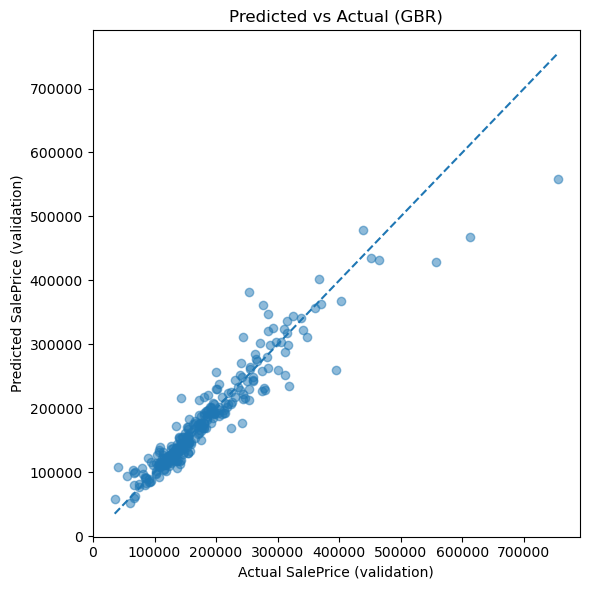

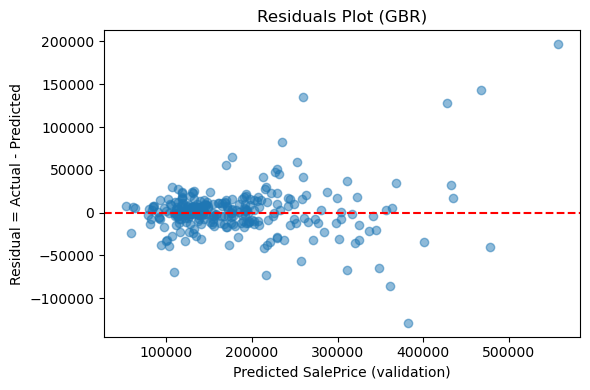

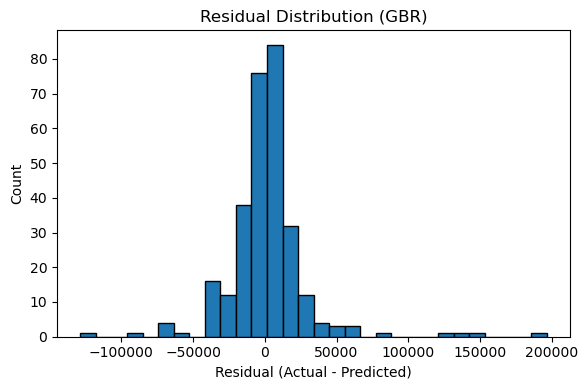

In [42]:
import matplotlib.pyplot as plt
y_val_pred_log = best_pipeline.predict(X_val)
y_val_pred = np.exp(y_val_pred_log)

residuals = y_val_raw - y_val_pred  # actual - predicted

# (A) Predicted vs Actual scatter
plt.figure(figsize=(6,6))
plt.scatter(y_val_raw, y_val_pred, alpha=0.5)
plt.plot([y_val_raw.min(), y_val_raw.max()],
         [y_val_raw.min(), y_val_raw.max()],
         linestyle="--")
plt.xlabel("Actual SalePrice (validation)")
plt.ylabel("Predicted SalePrice (validation)")
plt.title(f"Predicted vs Actual ({best_type})")
plt.tight_layout()
plt.show()

# (B) Residuals vs Predicted
plt.figure(figsize=(6,4))
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted SalePrice (validation)")
plt.ylabel("Residual = Actual - Predicted")
plt.title(f"Residuals Plot ({best_type})")
plt.tight_layout()
plt.show()

# (C) Histogram of residuals
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor="black")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.title(f"Residual Distribution ({best_type})")
plt.tight_layout()
plt.show()